# SIT720 Assignment 3
Bryon Baker

Student number: 85031775

In [1]:
!pip3 install numpy
!pip3 install pandas
!pip3 install scikit-learn

You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.


In [77]:
import warnings
import random
import pandas as pd # dataframe manipulation
import numpy as np # linear algebra
import seaborn as sn
import matplotlib.pyplot as plt

# Configure ssl for unverified content so we can load a dataset from an unknown source (github).
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Question 1

Load and explore the training dataset. Explain the steps that you have taken.

In [78]:
import os

train_url = 'https://raw.githubusercontent.com/bryonbaker/datasets/main/SIT720/Ass3/ac_train_data.csv'
test_url = 'https://raw.githubusercontent.com/bryonbaker/datasets/main/SIT720/Ass3/ac_test_data.csv'
train_path = '/opt/app-root/src/datasets/SIT720/Ass3/ac_train_data.csv'
test_path = '/opt/app-root/src/datasets/SIT720/Ass3/ac_test_data.csv'

#
# Work out if the datasets are local. If not use a remote url. Preference is local.
#
print("Load datasets from local or remote resource:")
print("="*50)
if os.path.isfile(train_path):
    print("Training data is local")
    training_data = train_path
else:
    print("Training data is remote. Downloading file from: {}".format(train_url))
    training_data = train_url

if os.path.isfile(test_path):
    print("Test data is local")
    test_data = test_path
else:
    print("Test data is remote. Downloading file from: {}".format(test_url))
    test_data = test_url
print()

# Load the datasets from either local or remote.
train_df = pd.read_csv(training_data)
test_df = pd.read_csv(test_data)

Load datasets from local or remote resource:
Training data is local
Test data is local



In [79]:
# Ordinal encode the days of week.

oldCol = "dayofweek"
newCol = "dayofweeknum"
dayMap = {'Sun' : 0, 'Mon': 1, "Tue" : 2, "Wed" : 3, "Thu" : 4, "Fri" : 5, "Sat" : 6 }    # How to map the values

train_df[newCol] = train_df[oldCol].map(dayMap)    # Adds a new column with proper boolean values
train_df = train_df.drop([oldCol], axis=1)    # Drop the old column before renaming the new column to the name just dropped
train_df = train_df.rename(columns={newCol : oldCol})
      
train_df.head()

,sequence,load,ac,hourofday,dif,absdif,max,var,entropy,nonlinear,hurst,dayofweek
0,105541,2.245,0,0,0.987,0.987,6.215,3.074549,0.678886,0.052903,0.994071,0
1,105542,2.259,0,0,0.014,0.014,6.215,3.172867,0.667450,0.054829,0.994154,0
2,105543,2.269,0,0,0.010,0.010,6.215,3.270112,0.647777,0.056991,0.994220,0
3,105544,2.268,0,0,-0.001,0.001,6.215,3.303763,0.629227,0.057606,0.994150,0
4,105545,2.270,0,0,0.002,0.002,6.215,3.302744,0.621295,0.082640,0.994041,0


In [80]:
test_df[newCol] = test_df[oldCol].map(dayMap)    # Adds a new column with proper boolean values
test_df = test_df.drop([oldCol], axis=1)    # Drop the old column before renaming the new column to the name just dropped
test_df = test_df.rename(columns={newCol : oldCol})
      
test_df.head()

,sequence,load,ac,hourofday,dif,absdif,max,var,entropy,nonlinear,hurst,dayofweek
0,1,1.869,0,0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,1
1,2,1.673,0,0,-0.196,0.196,0.0,0.0,0.0,0.0,0.0,1
2,3,1.660,0,0,-0.013,0.013,0.0,0.0,0.0,0.0,0.0,1
3,4,1.772,0,0,0.112,0.112,0.0,0.0,0.0,0.0,0.0,1
4,5,1.679,0,0,-0.093,0.093,0.0,0.0,0.0,0.0,0.0,1


In [81]:
# Split out the X and y from the datasets
train_X = train_df.drop(['ac'], axis=1)
train_y = train_df["ac"]
test_X = test_df.drop(['ac'], axis=1)
test_y = test_df['ac']

print("Training Dataset")
print(f"{train_X.head()}\n")
print(f"{train_y.head()}\n")

print("Testing Dataset")
print(f"{test_X.head()}\n")
print(f"{test_y.head()}\n")

Training Dataset
   sequence   load  hourofday    dif  absdif    max       var   entropy  \
0    105541  2.245          0  0.987   0.987  6.215  3.074549  0.678886   
1    105542  2.259          0  0.014   0.014  6.215  3.172867  0.667450   
2    105543  2.269          0  0.010   0.010  6.215  3.270112  0.647777   
3    105544  2.268          0 -0.001   0.001  6.215  3.303763  0.629227   
4    105545  2.270          0  0.002   0.002  6.215  3.302744  0.621295   

   nonlinear     hurst  dayofweek  
0   0.052903  0.994071          0  
1   0.054829  0.994154          0  
2   0.056991  0.994220          0  
3   0.057606  0.994150          0  
4   0.082640  0.994041          0  

0    0
1    0
2    0
3    0
4    0
Name: ac, dtype: int64

Testing Dataset
   sequence   load  hourofday    dif  absdif  max  var  entropy  nonlinear  \
0         1  1.869          0  0.000   0.000  0.0  0.0      0.0        0.0   
1         2  1.673          0 -0.196   0.196  0.0  0.0      0.0        0.0   
2     

Variable Correlation Matrix


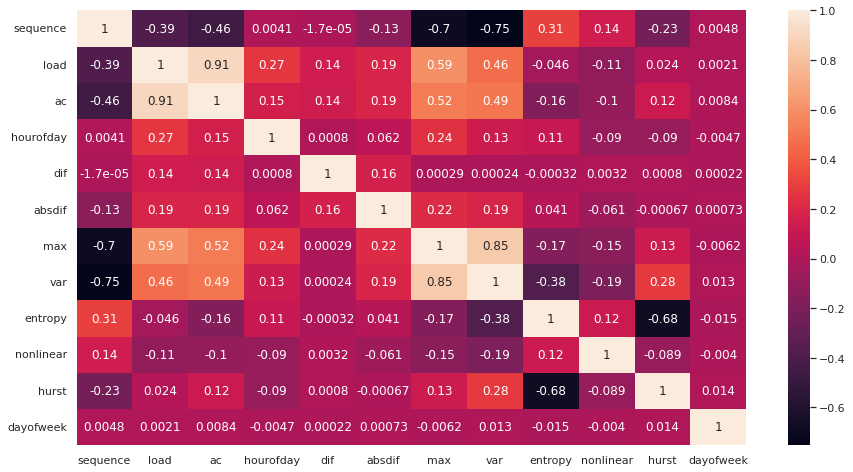

In [76]:
print("Variable Correlation Matrix")
corr_X = train_df.corr()
sn.set(rc = {'figure.figsize':(15,8)})
sn.heatmap(corr_X, annot=True)
plt.show()